In [34]:
import sys
import traceback
import pandas as pd
import numpy as np
import time
from copy import deepcopy

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import statsmodels.api as sm
from statsmodels.api import OLS

from scipy import sparse

import pickle

from IPython.display import display, HTML, Markdown

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
pd.set_option('display.width', 15000)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('poster')
%matplotlib inline

from surprise import Dataset, Reader
from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, \
SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNBaseline

from recommender import plot_cm, get_results, show_results, IO, show_summaries, get_X
from recommender import ModeClassifier, BaselineMean, BaselineRegression, ALS1, ALS2, RS_surprise, RS_sklearn

In [2]:
city = 'Champaign'
fig_dir = 'figs/modeling/{}/'.format(city)
data_dir = 'data/{}/'.format(city)

dfb = pd.read_pickle(data_dir + 'business.pkl')
dfu = pd.read_pickle(data_dir + 'user.pkl')

X_train, y_train, X_test, y_test, X_cv, y_cv = IO(data_dir + 'data_split.pkl').read_pickle()

(X_train, column_names) = get_X(X_train, dfb, dfu, return_columns=True)
X_test = get_X(X_test, dfb, dfu)
X_cv = get_X(X_cv, dfb, dfu)

IO(data_dir + '05_data_split.pkl').to_pickle([X_train, y_train, X_test, y_test, X_cv, y_cv])

del dfb
del dfu

Motivation of content filtering:

By merging the user.csv and business.csv through the user_id and business_id in review, we get a complete X (predictor) matrix. From EDA we find that review score is strongly associated with some of the properties of users, or can be differented greatly on some attributed of restaurants. Therefore, we decide to build content filtering models, including linear regression, ridge regression, logistic regression and random forest regressor. 

Before building the model, we preprocess the data by dropping certain uncorrelated variables, such as longitutde, latitude and postal code, as well as some string varibles, such as names, friends and so on. We deal with the missing values with imputation. Also, we didn't include all the over 100 variables into consideration, because some of them don't have strong and clear relationships with review score but increase the multicollinearity and sparsity of predictor matrix.

Instead, we pick 51 important predictors through EDA, which shows some relationships with review stars. For example, as shown in the EDA, review stars have various distributions on different dummy attributes of restaurant, such as different bestnight, music, food restriction, ambience and "good for" emphasis. Also, some of the categories in categorical attributes of restaurant show different patterns with others. Instead of taking dummy, we group by the different pattern and encode the categories according to their effect on review stars based on EDA. For instance, for attribute "RestaurantAttire", only "formal" appear a different pattern compared with other categories in the box plot. So we only encode it with 1 and other categories with 0.
For properties of users, we include variables that shows strong relationships with review stars, such as users'average star, fans, review count etc. 

### OLS & Significance of Coefficients

In [3]:
X_subset = sm.add_constant(X_train)
ols_sm = sm.OLS(y_train, X_subset)
fit_sm = ols_sm.fit()
print(fit_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     224.6
Date:                Mon, 04 Dec 2017   Prob (F-statistic):               0.00
Time:                        21:19:42   Log-Likelihood:                -18430.
No. Observations:               12342   AIC:                         3.695e+04
Df Residuals:                   12299   BIC:                         3.727e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9120      0.071    -26.835      0.0

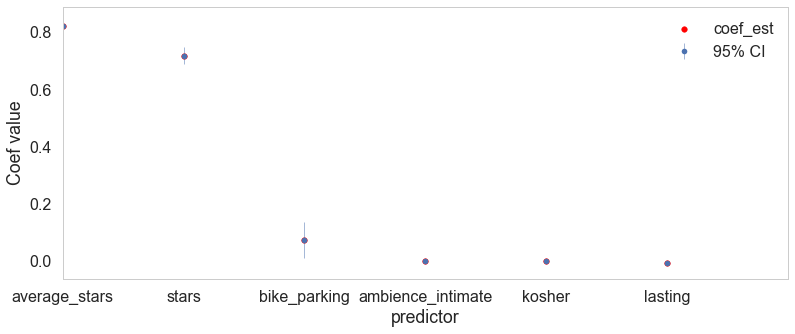

In [188]:
sig_b = []

for i in range(len(sig_vars) - 1):
    row={}
    row["predictor"] = column_names[sig_vars[i+1] - 1]
    row["coef"] = fit_sm.params[sig_vars[i+1]]
    row["CI 2.5"] = fit_sm.conf_int()[sig_vars[i+1]][0]
    row["CI 97.5"] = fit_sm.conf_int()[sig_vars[i+1]][1]
    sig_b.append(row)

sig_b_df = pd.DataFrame(sig_b)
sig_b_df = sig_b_df.sort_values("coef", ascending=False)
sig_b_df[["predictor","coef","CI 2.5","CI 97.5"]].head()

plt.figure(figsize=(13,5))

plt.errorbar(range(sig_b_df.shape[0]), 0.5*sig_b_df["CI 97.5"]+0.5*sig_b_df["CI 2.5"],  yerr=0.5*(sig_b_df["CI 97.5"]-sig_b_df["coef"])+0.5*(sig_b_df["coef"]-sig_b_df["CI 2.5"]), fmt='.', marker=None, elinewidth=0.5, label="95% CI")
plt.scatter(range(sig_b_df.shape[0]), sig_b_df["coef"], color='red', label="coef_est", marker='.') 
plt.xlim((0,sig_b_df.shape[0]))
plt.xticks(range(6), sig_b_df['predictor'])
plt.xlabel("predictor")
plt.ylabel("Coef value")
plt.legend()

First of all, we perform general OLS to have a preliminary understanding of content filtering. 6 out of our 51 predictors in the model are significant/important: users' average stars, restaurants'average stars, restaurants'bike parking, restaurants'ambience is intimate, restaurants' food restriction is kosher and years users started to use yelp. We don't feel surprise to see the first two predictors since they play a main role in all of our models. In addition, the other predictors are also apparent indicators of high review score according to EDA.

In [170]:
is_significant = fit_sm.pvalues < 0.05
sig_vars = [i for i in range(len(is_significant)) if is_significant[i]]
print('There are {} statistically significant coefficients (p < 0.05):'.format(len(sig_vars)))

There are 7 statistically significant coefficients (p < 0.05):


In [5]:
es = RS_sklearn(estimator=LinearRegression()).fit(X_train, y_train)

### Linear regression

Fitting time: 0.0296 s.  
            RMSE on training set: 1.0772.  
            RMSE on test set: 1.0973.  
            $R^2$ on training set: 0.4341.   
            $R^2$ on test set: 0.4279.  
            Classification accuracy on training set: 0.3811.  
            Classification accuracy on test set: 0.3929.
            

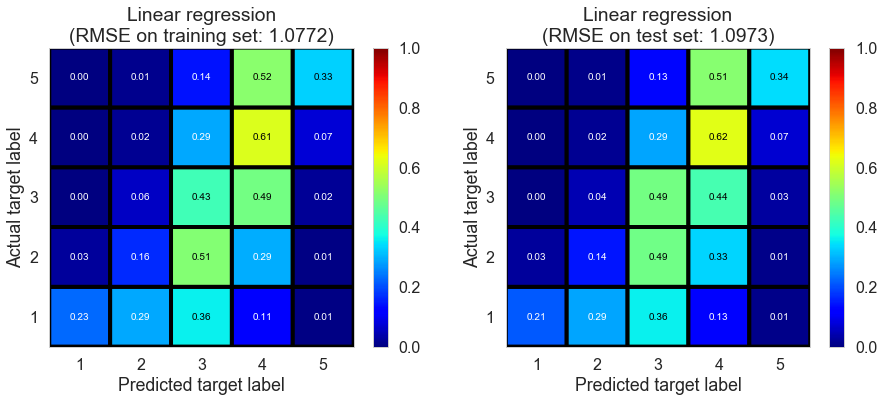

In [6]:
show_results(es, 'Linear regression', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, \
             show_cv=False)

Linear Regression result already indicates a great performance on test set compared with Baseline (Regression) model. Similar criterion values on both training and test set means including more attributes and using content filtering could fix overfitting well. In the following, we would implement certain models we learn from class to see if we could improve it.

In [7]:
es = RS_sklearn(estimator=RidgeCV()).fit(X_train, y_train)

### Ridge regression

Fitting time: 0.0695 s.  
            RMSE on training set: 1.0772.  
            RMSE on test set: 1.0973.  
            $R^2$ on training set: 0.4341.   
            $R^2$ on test set: 0.4279.  
            Classification accuracy on training set: 0.3811.  
            Classification accuracy on test set: 0.3929.
            

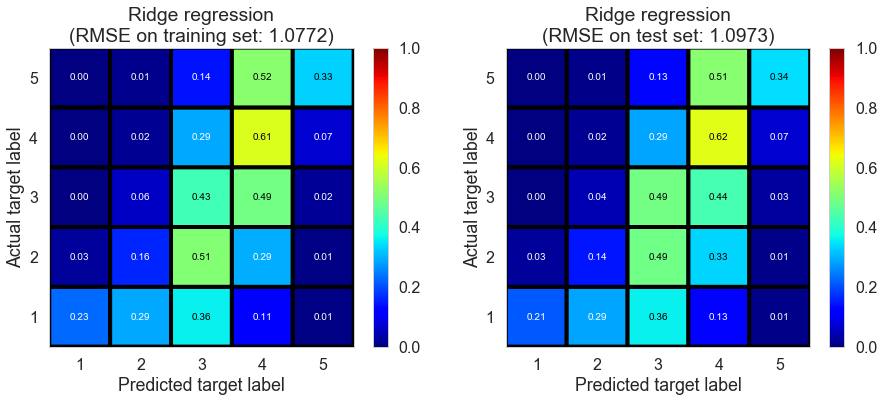

In [8]:
show_results(es, 'Ridge regression', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, \
             show_cv=False)

In [35]:
es = RS_sklearn(estimator=LassoCV()).fit(X_train, y_train)

### Lasso regression

Fitting time: 0.2893 s.  
            RMSE on training set: 1.0786.  
            RMSE on test set: 1.0961.  
            $R^2$ on training set: 0.4326.   
            $R^2$ on test set: 0.4291.  
            Classification accuracy on training set: 0.3818.  
            Classification accuracy on test set: 0.3923.
            

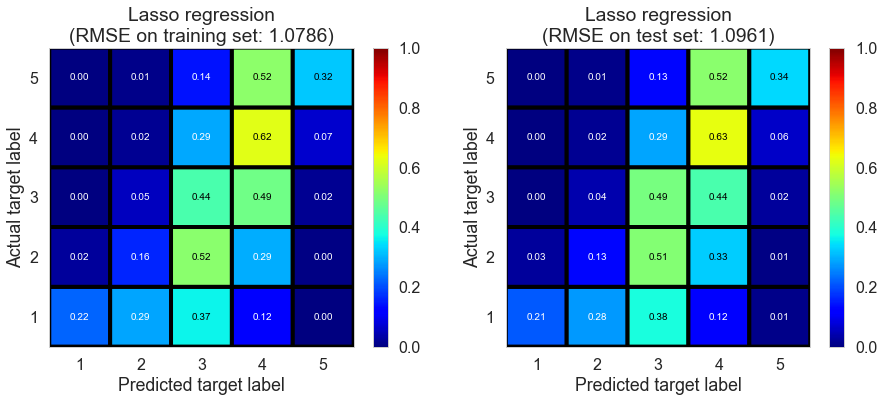

In [36]:
show_results(es, 'Lasso regression', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, \
             show_cv=False)

Regression with regularization doesn't seem to improve a lot from OLS. Reason might be we already select important predictors. In fact, we try to use the complete predictors matrix (over 100 predictors) and try with RidgeCV/LassoCV. Results seem to be even worse. Manually selecting predictors might be better in interpretation and prediction. So in the following we keep using the selected predictor matrix rather than keep trying dimension reduction model such as stepwise/PCA.

In [9]:
es = RS_sklearn(LogisticRegressionCV(class_weight='balanced')).fit(X_train, y_train)

### Logistic regression

Fitting time: 2.5542 s.  
            RMSE on training set: 1.3889.  
            RMSE on test set: 1.4052.  
            $R^2$ on training set: 0.0591.   
            $R^2$ on test set: 0.0618.  
            Classification accuracy on training set: 0.4784.  
            Classification accuracy on test set: 0.4743.
            

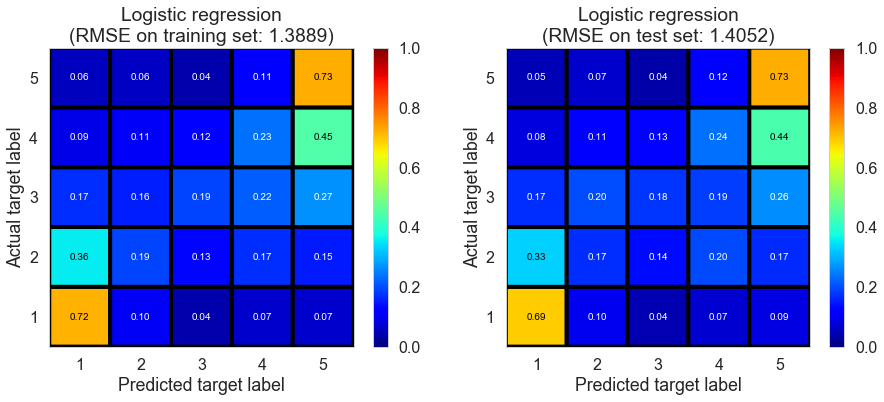

In [10]:
show_results(es, 'Logistic regression', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, \
             show_cv=False)

Besides regression model, we could also implement classification model. Here we try logistic regression with cross validation. Classification accuracy seem to improve compared with regression model, but RMSE get worse on both training and test set. As a matter of fact, we consider RMSE as a more important assessment because we had better not to punish at the same scale between predicting 5 as 1 and predicitng 5 as 4. This also explains why classification model doesn't work as well as regression model due to the same punishment scale in loss function. So we no longer consider other classification models such as SVM etc.

In [11]:
es = RS_sklearn(RandomForestRegressor(n_estimators=50, max_depth=7)).fit(X_train, y_train)

### Random forest regressor

Fitting time: 1.4386 s.  
            RMSE on training set: 1.0262.  
            RMSE on test set: 1.0858.  
            $R^2$ on training set: 0.4863.   
            $R^2$ on test set: 0.4398.  
            Classification accuracy on training set: 0.4131.  
            Classification accuracy on test set: 0.4131.
            

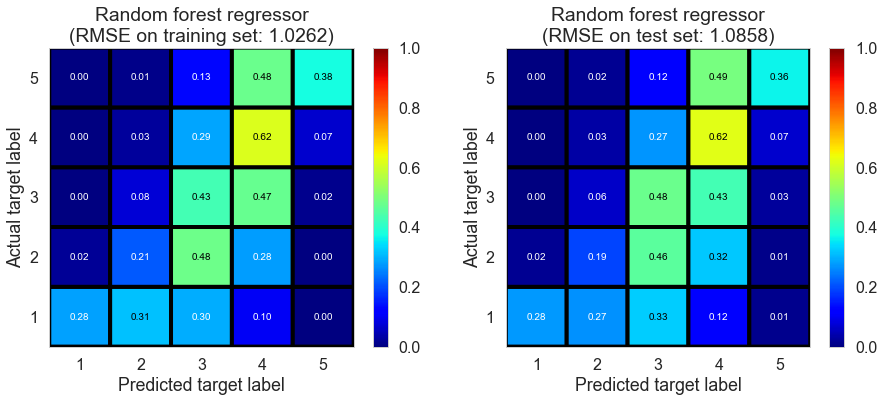

In [12]:
show_results(es, 'Random forest regressor', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, \
             show_cv=False)

We come back to regression model and try random forest regressor model. We choose appropriate parameters, including n_estimator and max_depth, through cross validation (GridSearchCV). Results show that this model performs better in RMSE and $R^2$ on both training and test set.

In [14]:
ns = list(range(1, X_train.shape[1]+1))
m32 = [RandomForestRegressor(n_estimators=n, max_features='auto').fit(X_train, y_train) for n in ns]

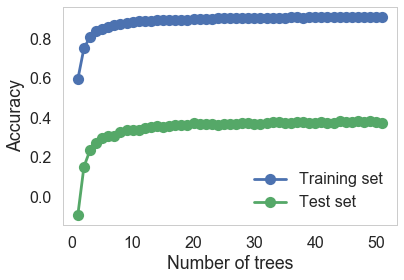

In [15]:
s32_train = [m.score(X_train, y_train) for m in m32]
s32_test = [m.score(X_test, y_test) for m in m32]
plt.plot(ns, s32_train, 'o-', label='Training set');
plt.plot(ns, s32_test, 'o-', label='Test set');
plt.legend();
plt.xlabel('Number of trees');
plt.ylabel('Accuracy');

In [29]:
n_trees = 44
ns_depth = list(range(1, X_train.shape[1]+1))
gs34 = GridSearchCV(RandomForestRegressor(n_estimators=n_trees), param_grid={'max_depth':ns_depth}, cv=5).fit(X_train, y_train)

The optimal value for the number of predictors is 6.


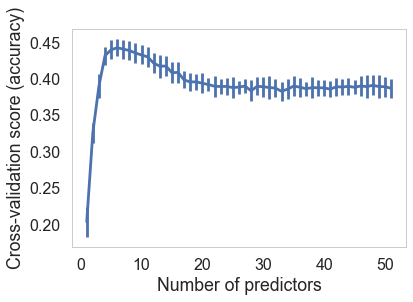

In [30]:
n_depth_best = ns_depth[np.argmax(gs34.cv_results_['mean_test_score'])]
print('The optimal value for the number of predictors is {}.'.format(n_depth_best))
plt.errorbar(ns_depth, gs34.cv_results_['mean_test_score'], gs34.cv_results_['std_test_score'], fmt='')
plt.xlabel('Number of predictors');
plt.ylabel('Cross-validation score (accuracy)');

### Random forest regressor

Fitting time: 0.9747 s.  
            RMSE on training set: 1.0449.  
            RMSE on test set: 1.0850.  
            $R^2$ on training set: 0.4674.   
            $R^2$ on test set: 0.4406.  
            Classification accuracy on training set: 0.4083.  
            Classification accuracy on test set: 0.4135.
            

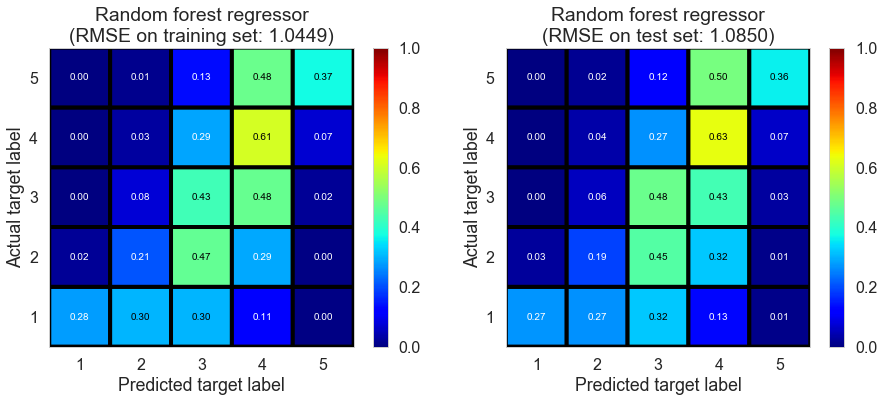

In [33]:
es = RS_sklearn(RandomForestRegressor(n_estimators=44, max_depth=n_depth_best)).fit(X_train, y_train)
show_results(es, 'Random forest regressor', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, \
             show_cv=False)